## Polynomial Regression

What if your data is actually more complex than a simple straight line? Surprisingly, you can actually use a linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called Polynomial Regression.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

The degree of the polynomial equation is determined by the complexity of the relationship between the variables. A quadratic equation (degree 2) can be used to fit a curve that has one bend, while a cubic equation (degree 3) can be used to fit a curve that has two bends, and so on.

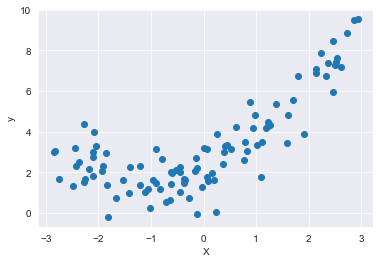

In [7]:
m = 100
X = 6 * np.random.rand(m,1) -  3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)
plt.scatter(X,y)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [8]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]
X_poly[0]

array([0.16412848, 0.02693816])

In [9]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
print(lin_reg.intercept_, lin_reg.coef_)

[2.10538305] [[1.02449505 0.48241799]]


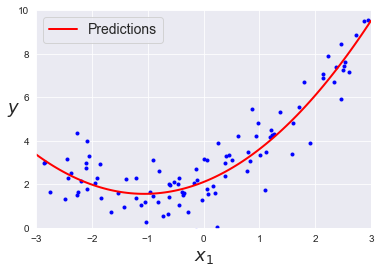

In [11]:
# plot the data 
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
#save_fig("quadratic_predictions_plot")
plt.show()

In [14]:
# Evaluate the model using cross-validation
from sklearn.model_selection import cross_val_score
scores = -cross_val_score(lin_reg, X_poly, y, scoring="neg_mean_squared_error", cv=10)
scores

array([0.1784467 , 1.11636249, 0.38614756, 1.87984213, 1.20008703,
       0.89457529, 0.61118469, 0.3683449 , 0.94809866, 0.96381321])

### Learning Curve

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)            

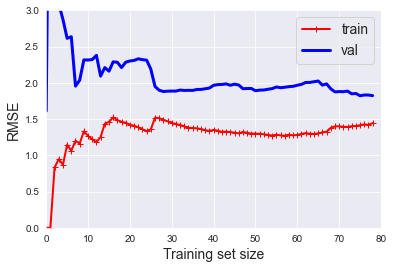

In [17]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # not shown in the book
#save_fig("underfitting_learning_curves_plot")   # not shown
plt.show()  

Explanation of the learning curve.<br>
First, let’s look at the performance on the training data: when there are just one or two instances in the training set, the model can fit them perfectly, which is why the curve starts at zero. <br><br>
But as new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly, both because the data is noisy and because it is not linear at all. So the error on the training data goes up until it reaches a plateau, at which point adding new instances to the training set doesn’t make the average error much better or worse. <br><br>
Now let’s look at the performance of the model on the validation data. When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite big. Then as the model is shown more training examples, it learns and thus the validation error slowly goes down. However, once again a straight line cannot do a good job modeling the data, so the error ends up at a plateau, very close to the other curve.,<br><br>
These learning curves are typical of an underfitting model. Both curves have reached a plateau; they are close and fairly high.

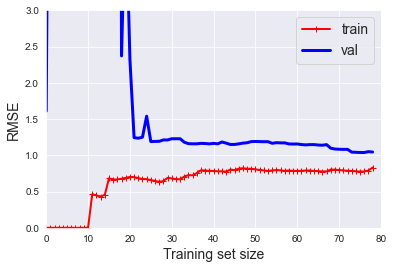

In [18]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           
#save_fig("learning_curves_plot") 
plt.show()                      

These learning curves look a bit like the previous ones, but there are two very important differences:<br><br>
1.The error on the training data is much lower than with the Linear Regression model.<br><br>
2.There is a gap between the curves. This means that the model performs signifi‐ cantly better on the training data than on the validation data, which is the hall‐ mark of an overfitting model. However, if you used a much larger training set, the two curves would continue to get closer.

###  Regularized Linear Models

#### 1. Ridge Regression

Ridge Regression (also called Tikhonov regularization) is a regularized version of Lin‐ ear Regression: a regularization term equal to α∑n θ2 is added to the cost function.
i=1 i
This forces the learning algorithm to not only fit the data but also keep the model
weights as small as possible. <br><br>
The hyperparameter α controls how much you want to regularize the model. If α = 0 then Ridge Regression is just Linear Regression. If α is very large, then all weights end up very close to zero and the result is a flat line going through the data’s mean.

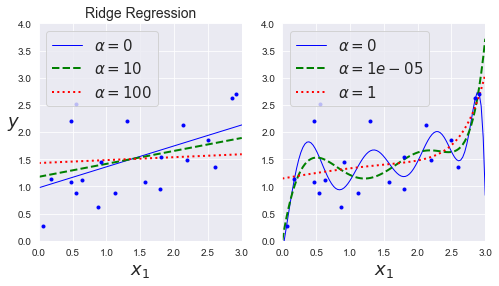

In [25]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.title("Ridge Regression", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

#save_fig("ridge_regression_plot")
plt.show()

In [19]:
from sklearn .linear_model import Ridge
ridge_reg = Ridge(alpha=1,solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.87642844]])

In [22]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.46619232])

The penalty hyperparameter sets the type of regularization term to use. Specifying "l2" indicates that you want SGD to add a regularization term to the cost function equal to half the square of the l2 norm of the weight vector: this is simply Ridge Regression.

#### 2. Lasso Regression

Least Absolute Shrinkage and Selection Operator Regression (simply called Lasso Regression) is another regularized version of Linear Regression: just like Ridge Regression, it adds a regularization term to the cost function, but it uses the l1 norm of the weight vector instead of half the square of the l2 norm

An important characteristic of Lasso Regression is that it tends to completely eliminate the weights of the least important features (i.e., set them to zero).Lasso Regression automatically performs feature selection and outputs a sparse model (i.e., with few nonzero feature weights).

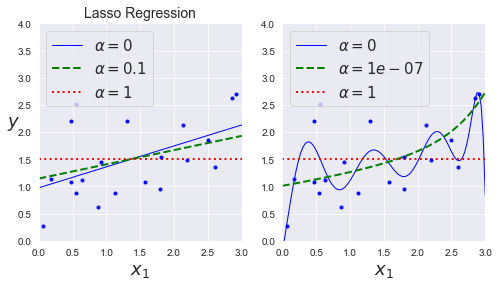

In [24]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.title("Lasso Regression", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

#save_fig("lasso_regression_plot")
plt.show()

In [26]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)

lasso_reg.predict([[1.5]])

array([1.53788174])

#### 3. Elastic Net

Elastic Net is a middle ground between Ridge Regression and Lasso Regression. The regularization term is a simple mix of both Ridge and Lasso’s regularization terms, and you can control the mix ratio r. When r = 0, Elastic Net is equivalent to Ridge Regression, and when r = 1, it is equivalent to Lasso Regression 

In [27]:
from sklearn.linear_model import ElasticNet

elastic_net =  ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

So when should you use Linear Regression, Ridge, Lasso, or Elastic Net? It is almost always preferable to have at least a little bit of regularization, so generally you should avoid plain Linear Regression. Ridge is a good default, but if you suspect that only a few features are actually useful, you should prefer Lasso or Elastic Net since they tend to reduce the useless features’ weights down to zero as we have discussed. In general, Elastic Net is preferred over Lasso since Lasso may behave erratically when the num‐ ber of features is greater than the number of training instances or when several fea‐ tures are strongly correlated.

#### 4. Early Stopping

A very different way to regularize iterative learning algorithms such as Gradient Descent is to stop training as soon as the validation error reaches a minimum. This is called early stopping.

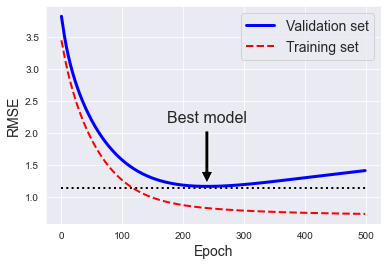

In [28]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       tol=-np.infty,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
#save_fig("early_stopping_plot")
plt.show()

In [31]:
from sklearn.base import clone
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None,
                       learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

print(best_epoch)
print(best_model)

239
SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
             random_state=42, tol=-inf, warm_start=True)


### Summary

Lasso and Ridge are two different regularization techniques used in machine learning to prevent overfitting of the model.<br><br>

The key difference between Lasso and Ridge is the way they regularize the coefficients of the model.<br>

Lasso uses L1 regularization which adds a penalty term proportional to the absolute value of the coefficients. This penalty term shrinks the coefficients towards zero and can lead to some coefficients becoming exactly zero. This makes Lasso useful for feature selection as it can set some coefficients to zero, effectively removing the corresponding features from the model.<br>

On the other hand, Ridge uses L2 regularization which adds a penalty term proportional to the square of the coefficients. This penalty term shrinks the coefficients towards zero but does not force any coefficients to become exactly zero. Ridge is useful when all the features are potentially relevant and there is no strong reason to remove any of them.<br>

In summary, Lasso is good for feature selection and producing a sparse model, while Ridge is good for preventing overfitting and producing a model that uses all the features.